# Classify images according to cell-type
In this notebook the goal is to classify the images according to their cell-type

# Setup
1. Import libraries
2. Setting up data sets
3. Initialize learning curve function

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [25]:
# from sklearn.model_selection import train_test_split

# data = pd.read_csv('./data_labels_mainData.csv')

# train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
# train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

# print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))

# # making data set smaller for faster compile

# _, train_data = train_test_split(train_data_big, test_size=0.2, random_state=42)
# _, test_data = train_test_split(test_data_big, test_size=0.2, random_state=42)
# _, val_data = train_test_split(val_data_big, test_size=0.2, random_state=42)

# print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980
Train data : 1188, Val Data: 396, Test Data: 396


# EDA
Exploring the data set

In [3]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9533,22266,58,22266.png,fibroblast,0,0
310,18717,4,18717.png,others,3,0
9480,21202,57,21202.png,inflammatory,1,0
7073,18114,44,18114.png,fibroblast,0,0
8977,14070,54,14070.png,epithelial,2,1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5937 entries, 9533 to 9349
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    5937 non-null   int64 
 1   patientID     5937 non-null   int64 
 2   ImageName     5937 non-null   object
 3   cellTypeName  5937 non-null   object
 4   cellType      5937 non-null   int64 
 5   isCancerous   5937 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 324.7+ KB


(array([1888., 2543., 4079., 1386.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

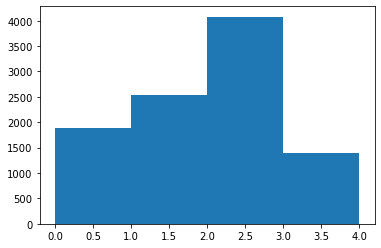

In [5]:
import matplotlib.pyplot as plt

target = data['cellType']

plt.hist(target, bins=np.arange(5))

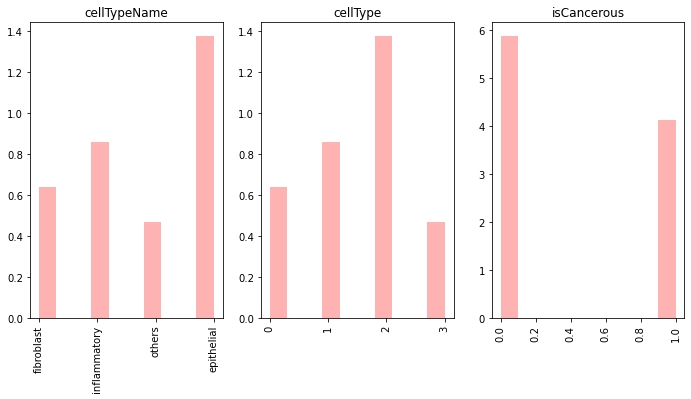

In [6]:
plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(data[col], alpha=0.3, color='r', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

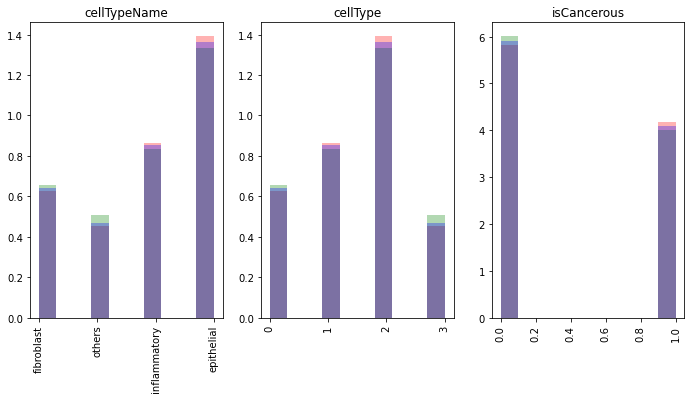

In [50]:
plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
    _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

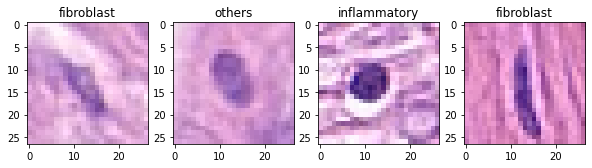

In [21]:
from PIL import Image

label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['cellType']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [22]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


### Observations
1. We observe that the data is evenly distributed among the train, test and validation sets.
2. The cell type data is slightly imbalanced as there are more sample of epithelial compared to the rest, but it is not too skewed such as a 1:9 thus we decide to keep it as is

### Further setups

In [3]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [4]:
# cellType needs to be string
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

# 1) NN model as Base model
We will use a simple NN model using Keras Sequential for our base model

### Setting up generators

In [5]:
import tensorflow as tf
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


### Setting up base model
Parameter settings for the base model:
1. units = HIDDEN_LAYER_DIM = 256
2. no reg
3. no dropout
4. sigmoid activation
5. epochs = 150

These values are estimates and would be change accordingly during hyperparameters tuning

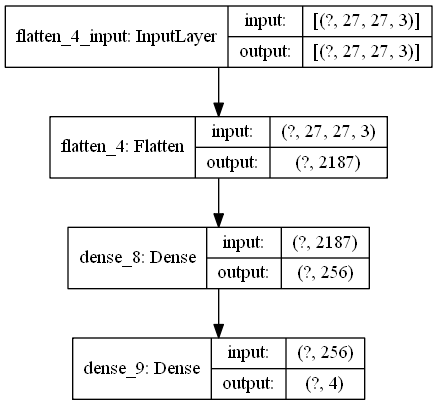

In [24]:
# base_model
# initialize layers
base_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

tf.keras.utils.plot_model(base_model, show_shapes=True)

Instructions for updating:
Please use Model.fit, which supports generators.


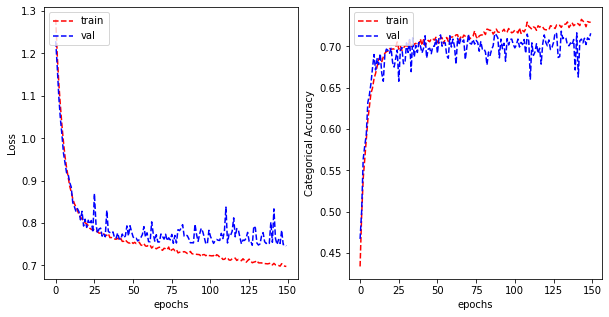

In [11]:
# compile model
base_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_base_model = base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

# # plot model performance
plot_learning_curve(history_base_model.history['loss'], history_base_model.history['val_loss'], 
                    history_base_model.history['categorical_accuracy'], history_base_model.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

### Hyperparameters tuning for base model using Keras Tuner
We will be adding l2 regularization in this tuning as well as a dropout layer
We will be using keras tuner to tune the following hyperparameters:
1. Dense layer units value (HIDDEN_LAYER_DIM)
2. l2 regularization lambda value
3. dropout value
4. Dense layer activation function

We will be using epochs = 75 for the Hyperband as we observe in the base model that the performance converges approximately at 50

In [13]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def model_builder(hp):
    # Dense layer unit value
    hp_units = hp.Int('units', min_value=192, max_value=320, step=32)
    # Regularization lambda value
    hp_reg_lambdas = hp.Choice('reg_lambda', values=[0.001, 0.005, 0.01])
    # dropout value
    hp_dropouts = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
    
    # initialize layers
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(units=hp_units, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
        tf.keras.layers.Dropout(hp_dropouts),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas))
    ])
    
    # compile model
    model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

    return model

# Instantiate the tuner and perform hypertuning
tuner_base_model = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=75,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='v1')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# extracting the image and labels from the generators as search function does not support generators directly
train_img,train_lables = train_generator.next()
val_img,val_lables = validation_generator.next()

In [14]:
# Execute search
tuner_base_model.search(train_img,train_lables,
             validation_data=(val_img,val_lables),batch_size = 32, callbacks=[stop_early])

# Print optimal hyperparameters
best_hps_base_model=tuner_base_model.get_best_hyperparameters(num_trials=1)[0]

print(f"""
 units: {best_hps_base_model.get('units')}
 lamda: {best_hps_base_model.get('reg_lambda')}
 dropout: {best_hps_base_model.get('dropout')}
""")

Trial 90 Complete [00h 00m 01s]
val_categorical_accuracy: 0.28125

Best val_categorical_accuracy So Far: 0.40625
Total elapsed time: 00h 01m 40s
INFO:tensorflow:Oracle triggered exit

 units: 320
 lamda: 0.001
 dropout: 0.2



Next we will build a model using the hyperparameters we got from keras tuner

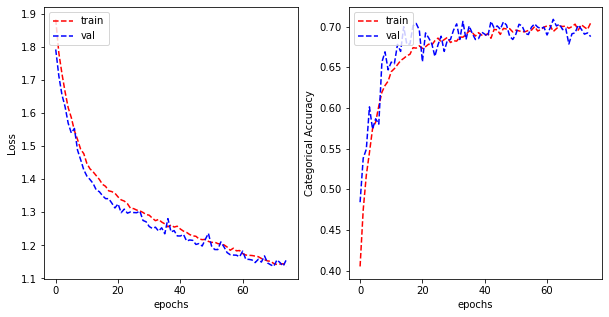

In [15]:
# base_model_tuned
# initialize layers
base_model_tuned = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(units=320, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])

# compile model
base_model_tuned.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_base_model_tuned = base_model_tuned.fit_generator(train_generator, validation_data = validation_generator, epochs=75, verbose=0)

# plot model performance
plot_learning_curve(history_base_model_tuned.history['loss'], history_base_model_tuned.history['val_loss'], 
                    history_base_model_tuned.history['categorical_accuracy'], history_base_model_tuned.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

## Testing the base models
Testing the base models with our test set

In [17]:
# Initialize test generator
test_data['cellType'] = test_data['cellType'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_img,test_labels = test_generator.next()

Found 1980 validated image filenames belonging to 4 classes.


<ipython-input-17-2cefe04de54d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


In [20]:
# Base model
base_model.evaluate(test_generator)

1980/1980 [==============================] - 18s 9ms/step - loss: 0.7904 - categorical_accuracy: 0.7035


[0.7904261946678162, 0.7035353779792786]

In [18]:
# Base model tuned
base_model_tuned.evaluate(test_generator)

1980/1980 [==============================] - 5s 2ms/step - loss: 1.1909 - categorical_accuracy: 0.6778


[1.1908752918243408, 0.6777777671813965]

Obervation: 

# 2) CNN model
Next we will experiment using CNN models such as leNet and VGG models to classify the images.

In [19]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [20]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)